In [76]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
from IPython.display import display, HTML

In [77]:
cwd = os.getcwd()
print(cwd)

C:\Users\Marco\Desktop\HyenaDNA\Redo_Outs


In [78]:
# Function to parse accuracy files
def parse_accuracy_file(file_path):
    print(f"Parsing file: {file_path}")
    with open(file_path, 'r') as file:
        data = json.load(file)
    print(f"Parsed data: {data}")
    return data['train_accuracies'], data['test_accuracies']

In [79]:
# Function to scan directories and parse data
def scan_directories(base_dir):
    all_data = {}
    epoch_50_data = {}
    print(f"Scanning base directory: {base_dir}")
    for root, dirs, files in os.walk(base_dir):
        print(f"Current root: {root}")
        for dir_name in dirs:
            print(f"Found directory: {dir_name}")
            if dir_name.startswith('all_'):
                dataset = dir_name.split('all_')[1]  # Get the dataset name after 'all_'
                dir_path = os.path.join(root, dir_name)
                print(f"Processing directory: {dir_path} for dataset: {dataset}")
                for file in os.listdir(dir_path):
                    print(f"Found file: {file}")
                    if file.startswith('accuracies_') and file.endswith('.json'):
                        parts = file.split('_')
                        condition = parts[3]  # e.g., "pi" or "scratch"
                        epochs = parts[2]
                        size = parts[4].split('.')[0]  # "1k" or "1m"
                        
                        if condition == 'pi' and (epochs == '15' or epochs == '50') and (size == '1k' or size == '1m'):
                            seed = 'pi'
                            file_path = os.path.join(dir_path, file)
                            train_accuracies, test_accuracies = parse_accuracy_file(file_path)
                            if epochs == '15':
                                if dataset not in all_data:
                                    all_data[dataset] = {}
                                if size not in all_data[dataset]:
                                    all_data[dataset][size] = {}
                                if condition not in all_data[dataset][size]:
                                    all_data[dataset][size][condition] = {}
                                all_data[dataset][size][condition][seed] = {
                                    "train_accuracies": train_accuracies,
                                    "test_accuracies": test_accuracies
                                }
                            elif epochs == '50':
                                epoch_50_data[dataset] = {
                                    "train_accuracies": train_accuracies,
                                    "test_accuracies": test_accuracies
                                }
                            print(f"Added data for dataset: {dataset}, size: {size}, condition: {condition}, seed: {seed}")
                        
                        elif epochs == '15' and (size == '1k' or size == '1m'):
                            if condition == 'scratch':
                                seed = parts[-1].split('.')[0]  # For scratch files with seeds
                            else:
                                seed = 'pi'
                            file_path = os.path.join(dir_path, file)
                            train_accuracies, test_accuracies = parse_accuracy_file(file_path)

                            if dataset not in all_data:
                                all_data[dataset] = {}
                            if size not in all_data[dataset]:
                                all_data[dataset][size] = {}
                            if condition not in all_data[dataset][size]:
                                all_data[dataset][size][condition] = {}
                            all_data[dataset][size][condition][seed] = {
                                "train_accuracies": train_accuracies,
                                "test_accuracies": test_accuracies
                            }
                            #print(f"Added data for dataset: {dataset}, size: {size}, condition: {condition}, seed: {seed}")
    #print(f"All data collected: {all_data}")
    #print(f"Epoch 50 data collected: {epoch_50_data}")
    return all_data, epoch_50_data

In [80]:
# Function to plot accuracies side by side
def plot_accuracies_side_by_side(data, size):
    label_mapping = {
        'pi_pi': 'pre-trained weights',
        'scratch_22': 'scratch (seed = 22)',
        'scratch_42': 'scratch (seed = 42)',
        'scratch_2222': 'scratch (seed = 2222)'
    }
    
    title_mapping = {
        'cohn': 'Cohn - Human Enhancers COHN',
        'enhancers': 'Enhancers - Human Enhancers Ensembl',
        'intergencod': 'Intergencod - Coding vs Intergenomic Sequences',
        'ocr': 'Ocr - Human OCR Ensembl'
    }
    
    for dataset, sizes in data.items():
        if size in sizes:
            fig, axes = plt.subplots(1, 2, figsize=(20, 8))
            conditions = sizes[size]

            for accuracy_type, ax in zip(['train_accuracies', 'test_accuracies'], axes):
                for condition, seeds in conditions.items():
                    for seed, accuracies in seeds.items():
                        original_label = f"{condition}_{seed}"
                        label = label_mapping.get(original_label, original_label)
                        ax.plot(range(1, len(accuracies[accuracy_type]) + 1), accuracies[accuracy_type], marker='o', label=label)

                ax.set_xlabel('Epochs')
                ax.set_ylabel('Accuracy')
                ax.set_title(f'{title_mapping.get(dataset, dataset.capitalize())} ({size}) - {accuracy_type.replace("_", " ").capitalize()}')
                ax.legend()
                ax.grid(True)

            suptitle = f'{title_mapping.get(dataset, dataset.capitalize())} - {size} Accuracies'
            plt.suptitle(suptitle)
            plt.savefig(f"{suptitle.replace(' ', '_').replace('-', '').replace('(', '').replace(')', '')}.png")
            plt.show()
            print(f"Plots generated and saved for {dataset} ({size})")
        else:
            print(f"No data found for dataset: {dataset} with size: {size}")

In [83]:
# Function to plot epoch 50 accuracies side by side
def plot_epoch_50_accuracies_side_by_side(data):
    label_mapping = {
        'cohn': 'Human Enhancers COHN',
        'enhancers': 'Human Enhancers Ensembl',
        'intergencod': 'Coding vs Intergenomic Sequences',
        'ocr': 'Human OCR Ensembl'
    }

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    for accuracy_type, ax in zip(['train_accuracies', 'test_accuracies'], axes):
        for dataset, accuracies in data.items():
            label = label_mapping.get(dataset, dataset)
            ax.plot(range(1, len(accuracies[accuracy_type]) + 1), accuracies[accuracy_type], marker='o', label=label)

        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'Epoch 50 - {accuracy_type.replace("_", " ").capitalize()}')
        ax.legend()
        ax.grid(True)

    plt.suptitle('Epoch 50 - Accuracies')
    plt.savefig('Epoch_50_Accuracies.png')
    plt.show()
    print('Plots generated and saved for Epoch 50 - Accuracies')

In [84]:
# Set the base directory path to the current working directory
base_dir = os.getcwd()
print(f"Base directory: {base_dir}")


Base directory: C:\Users\Marco\Desktop\HyenaDNA\Redo_Outs


In [85]:
# Scan directories and parse data
all_data, epoch_50_data = scan_directories(base_dir)

Scanning base directory: C:\Users\Marco\Desktop\HyenaDNA\Redo_Outs
Current root: C:\Users\Marco\Desktop\HyenaDNA\Redo_Outs
Found directory: .ipynb_checkpoints
Found directory: all_cohn
Processing directory: C:\Users\Marco\Desktop\HyenaDNA\Redo_Outs\all_cohn for dataset: cohn
Found file: .ipynb_checkpoints
Found file: accuracies_cohn_15_pi_1k.json
Parsing file: C:\Users\Marco\Desktop\HyenaDNA\Redo_Outs\all_cohn\accuracies_cohn_15_pi_1k.json
Parsed data: {'train_accuracies': [63.08113035551504, 70.94947944153913, 71.44844792016504, 72.22088950726862, 72.6334980569016, 72.81581346255338, 73.76097490764285, 74.46144988725231, 75.52655567816534, 76.36136832509716, 77.93024036846903, 78.54915319291848, 79.85414767547857, 80.30034064194214, 81.16393993187161], 'test_accuracies': [68.78238341968913, 70.52389176741508, 71.37305699481865, 72.40932642487047, 70.75417386298216, 73.28727691421992, 72.75474956822107, 72.72596430627519, 72.4237190558434, 72.27979274611398, 72.79792746113989, 72.59643

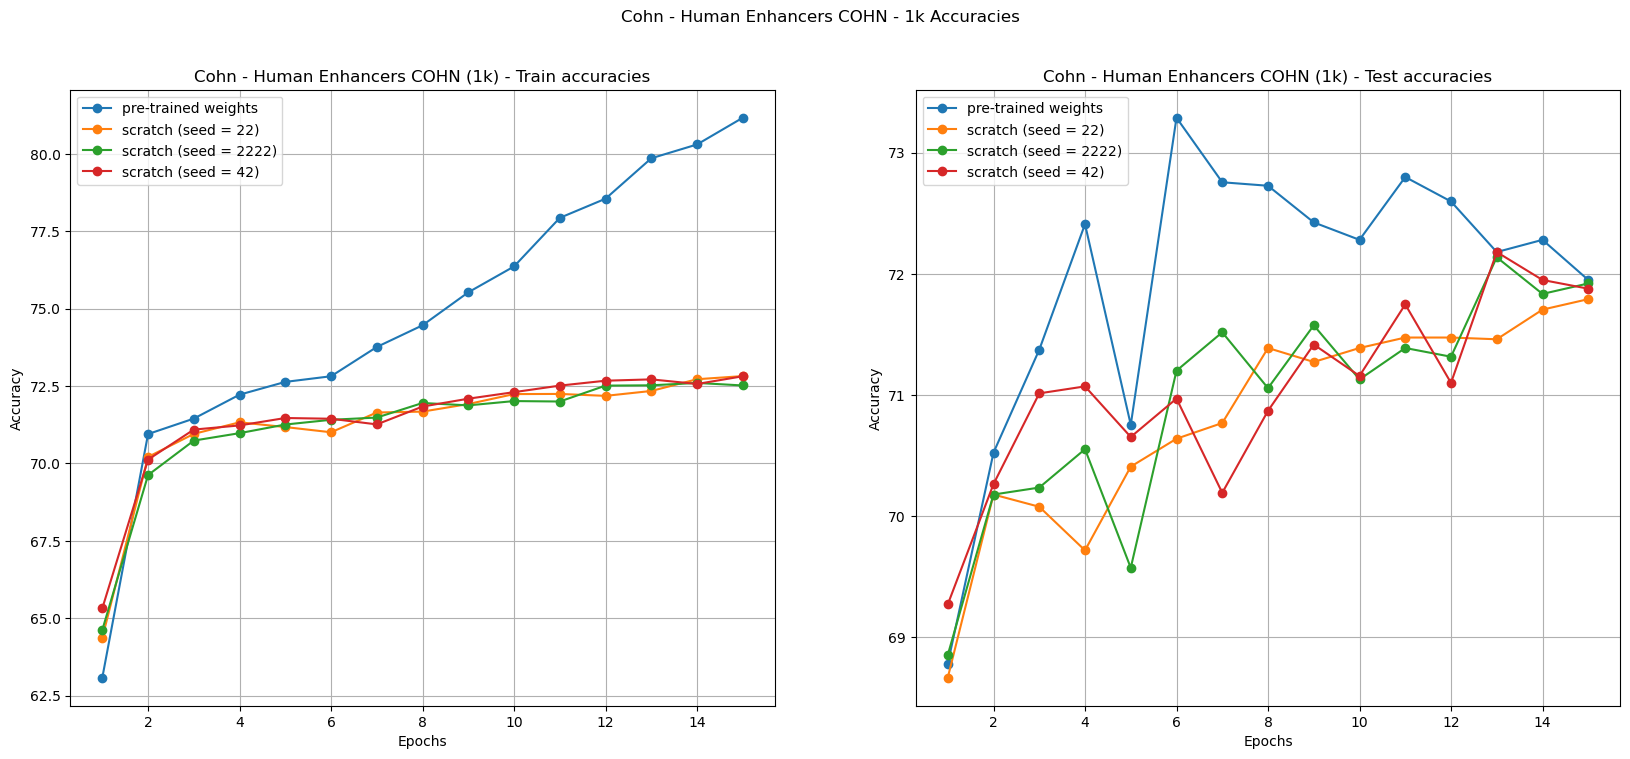

Plots generated and saved for cohn (1k)


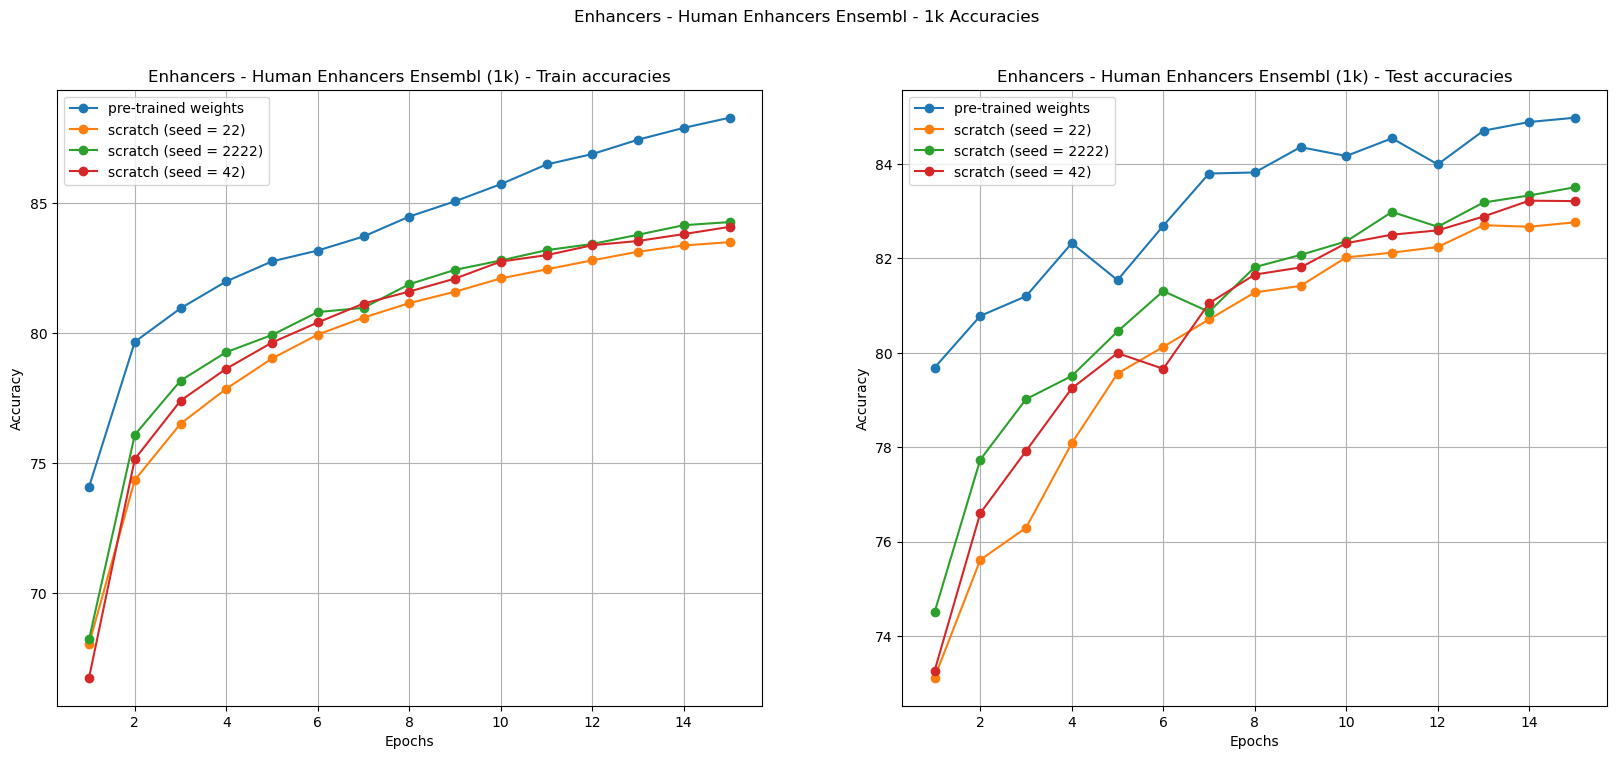

Plots generated and saved for enhancers (1k)


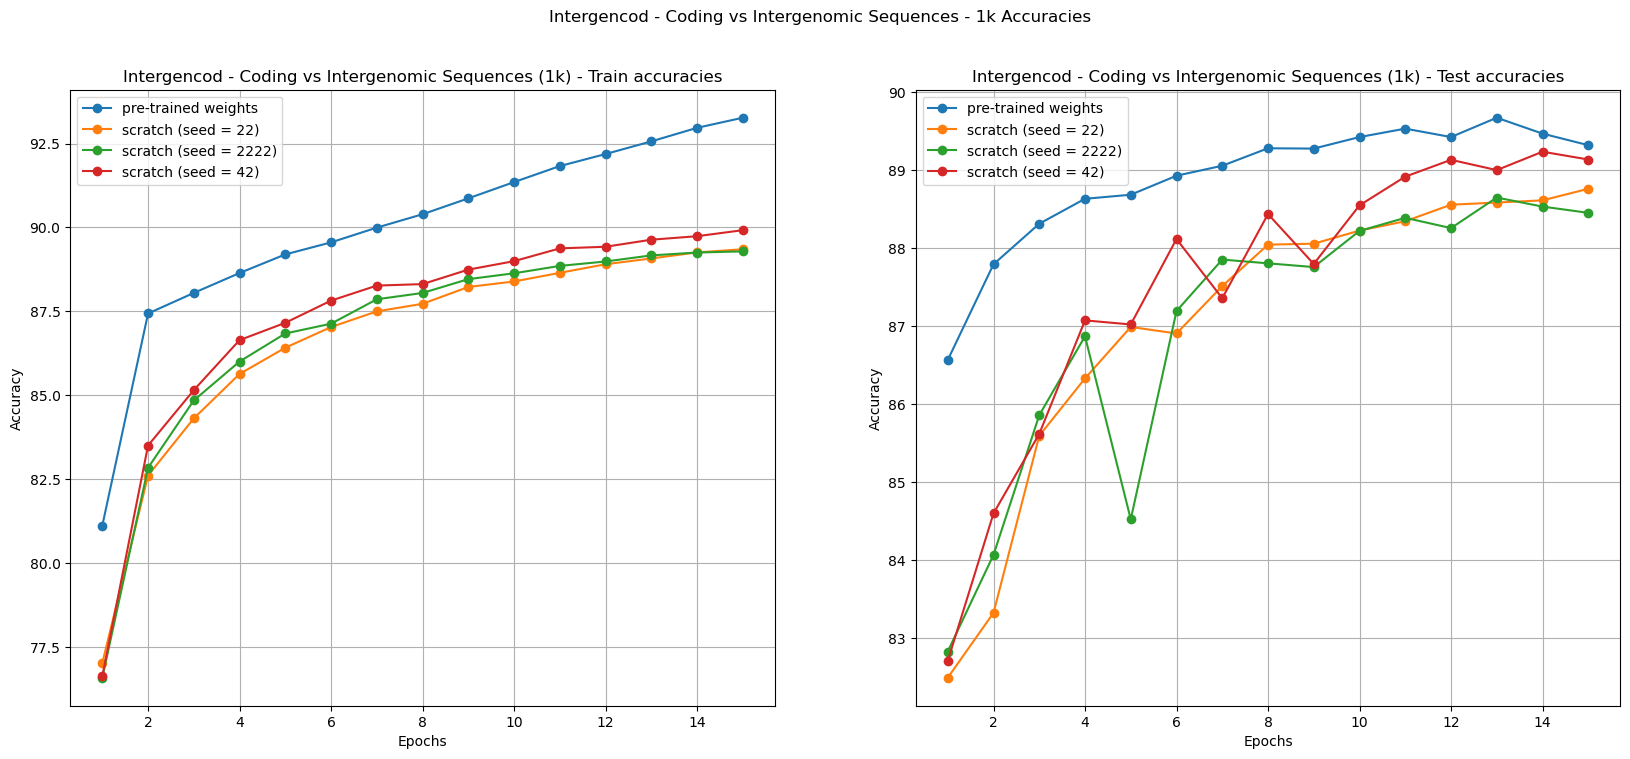

Plots generated and saved for intergencod (1k)


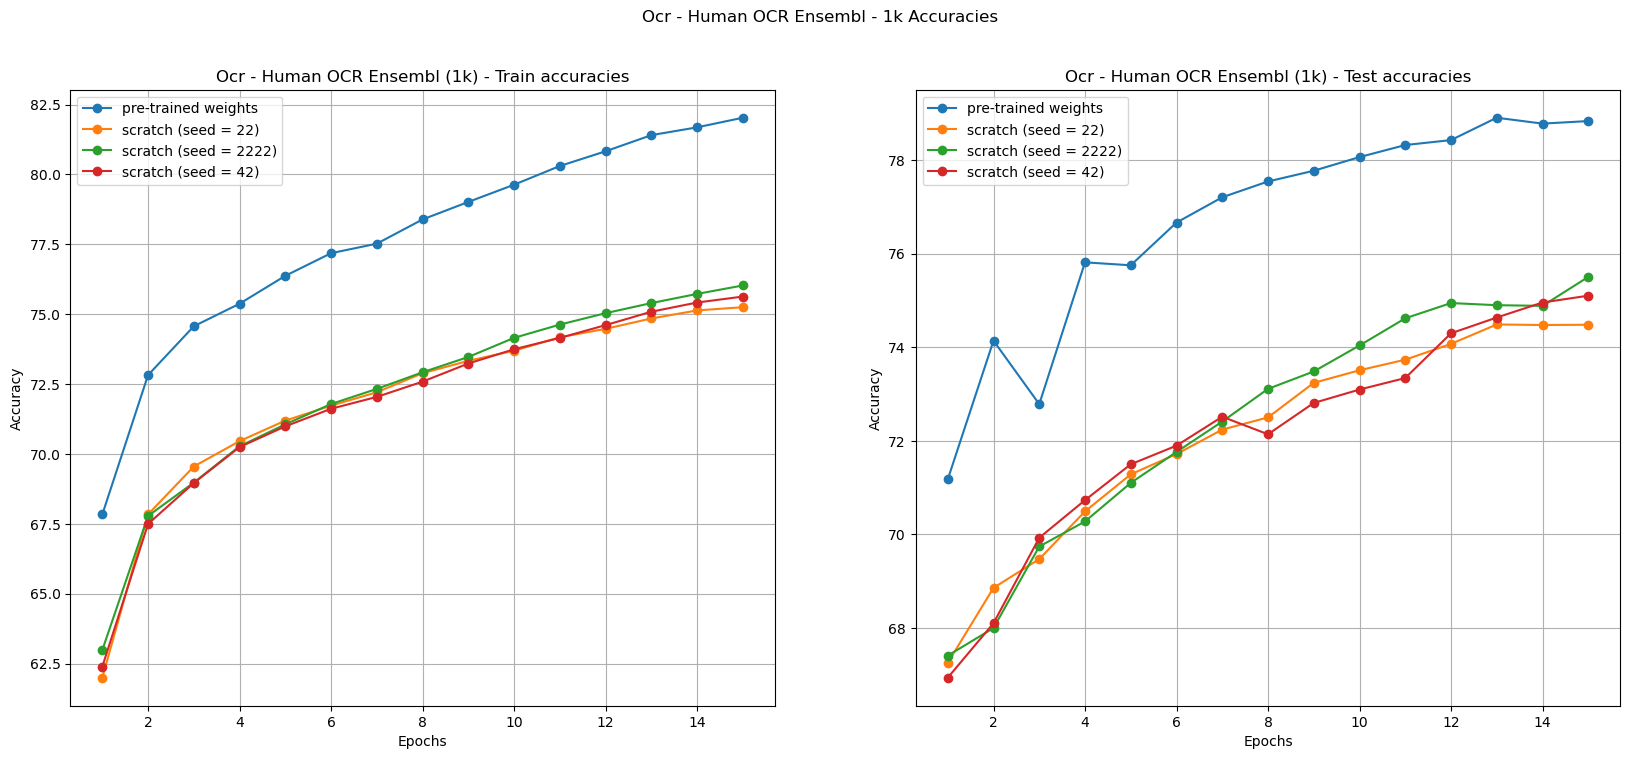

Plots generated and saved for ocr (1k)


In [86]:
# Plot training and test accuracies side by side for 1k files
plot_accuracies_side_by_side(all_data, '1k')

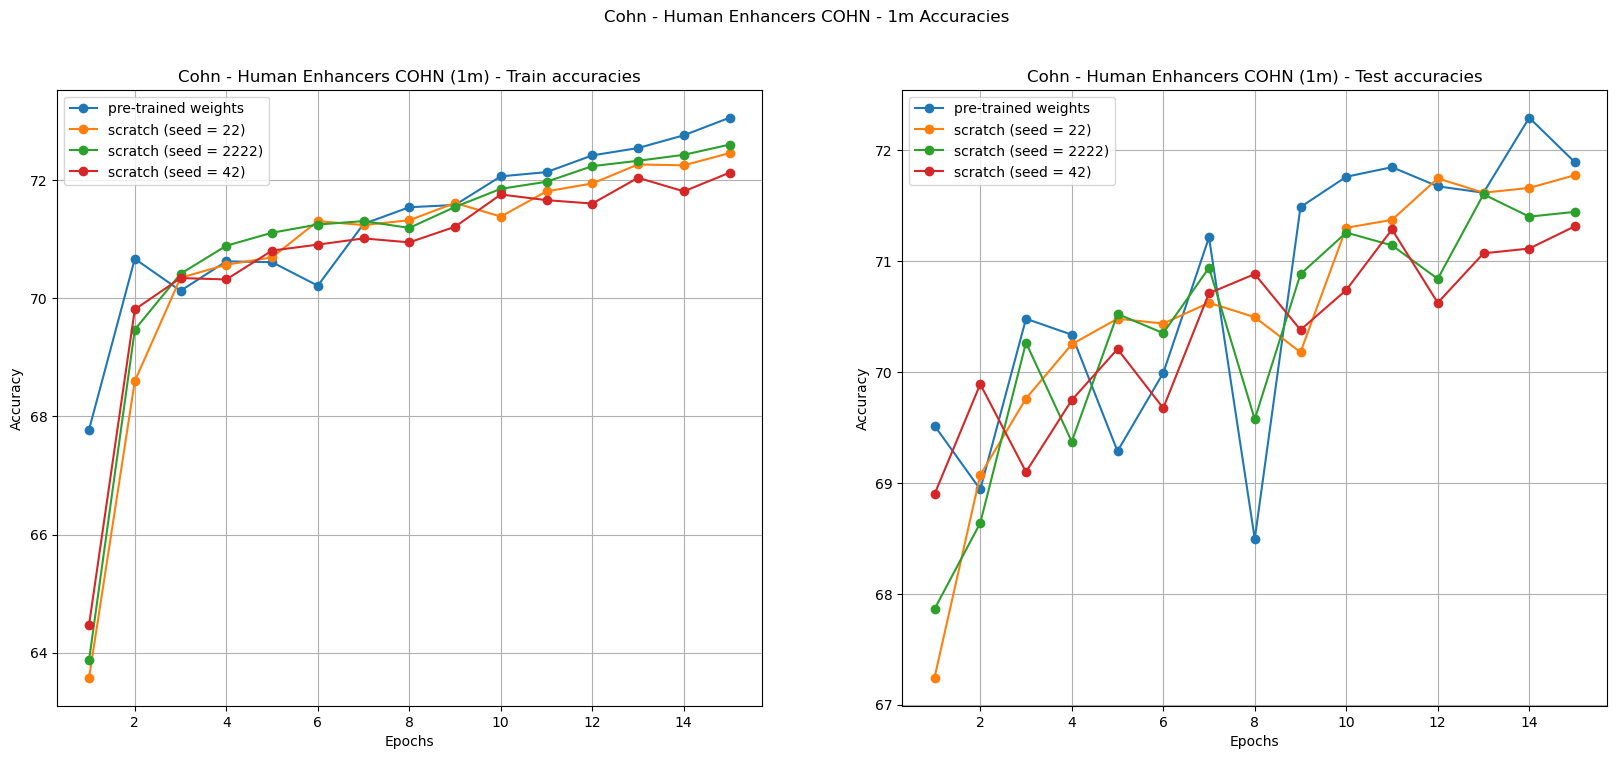

Plots generated and saved for cohn (1m)


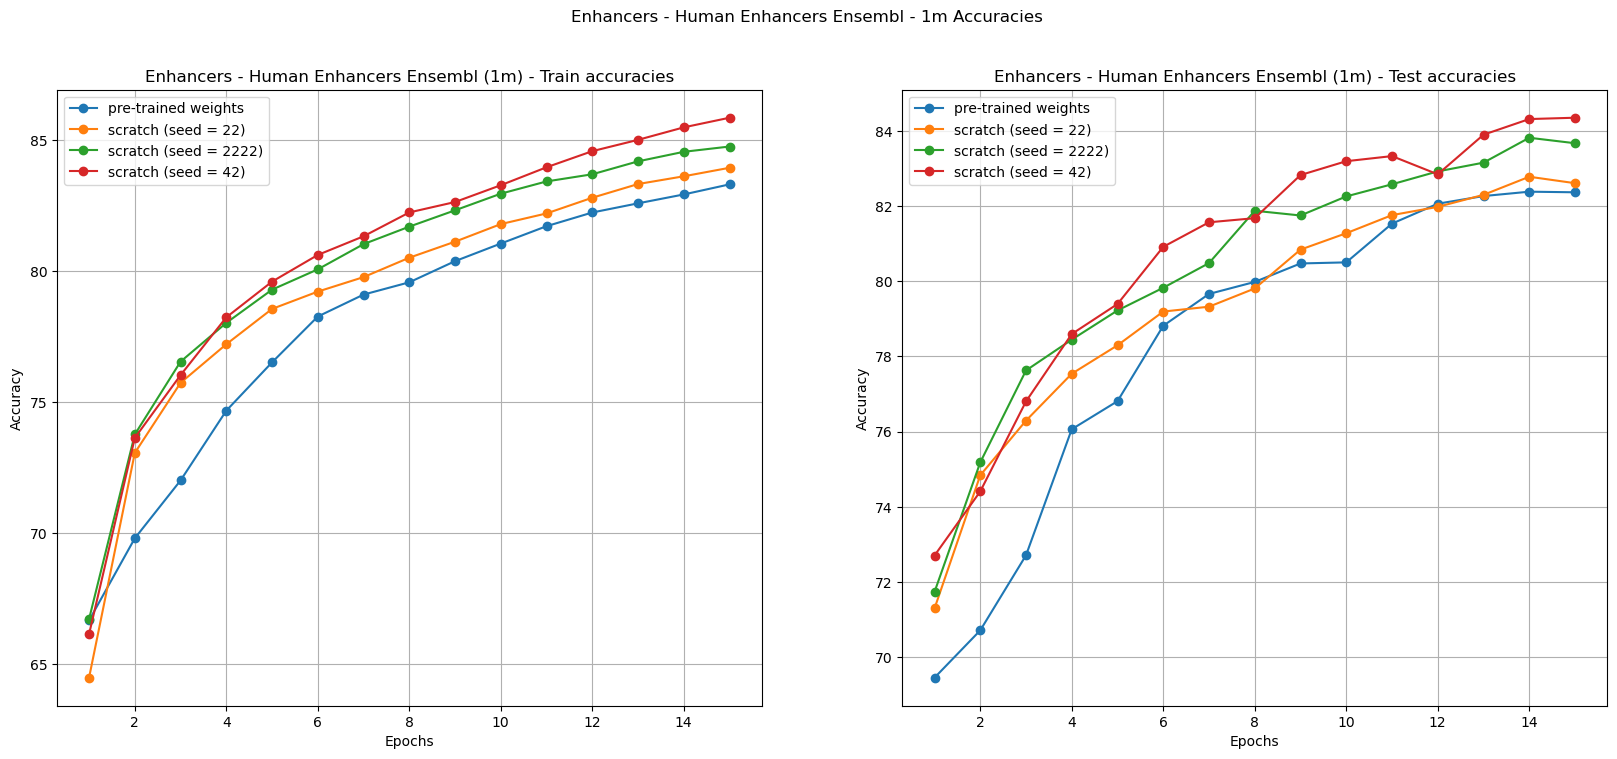

Plots generated and saved for enhancers (1m)


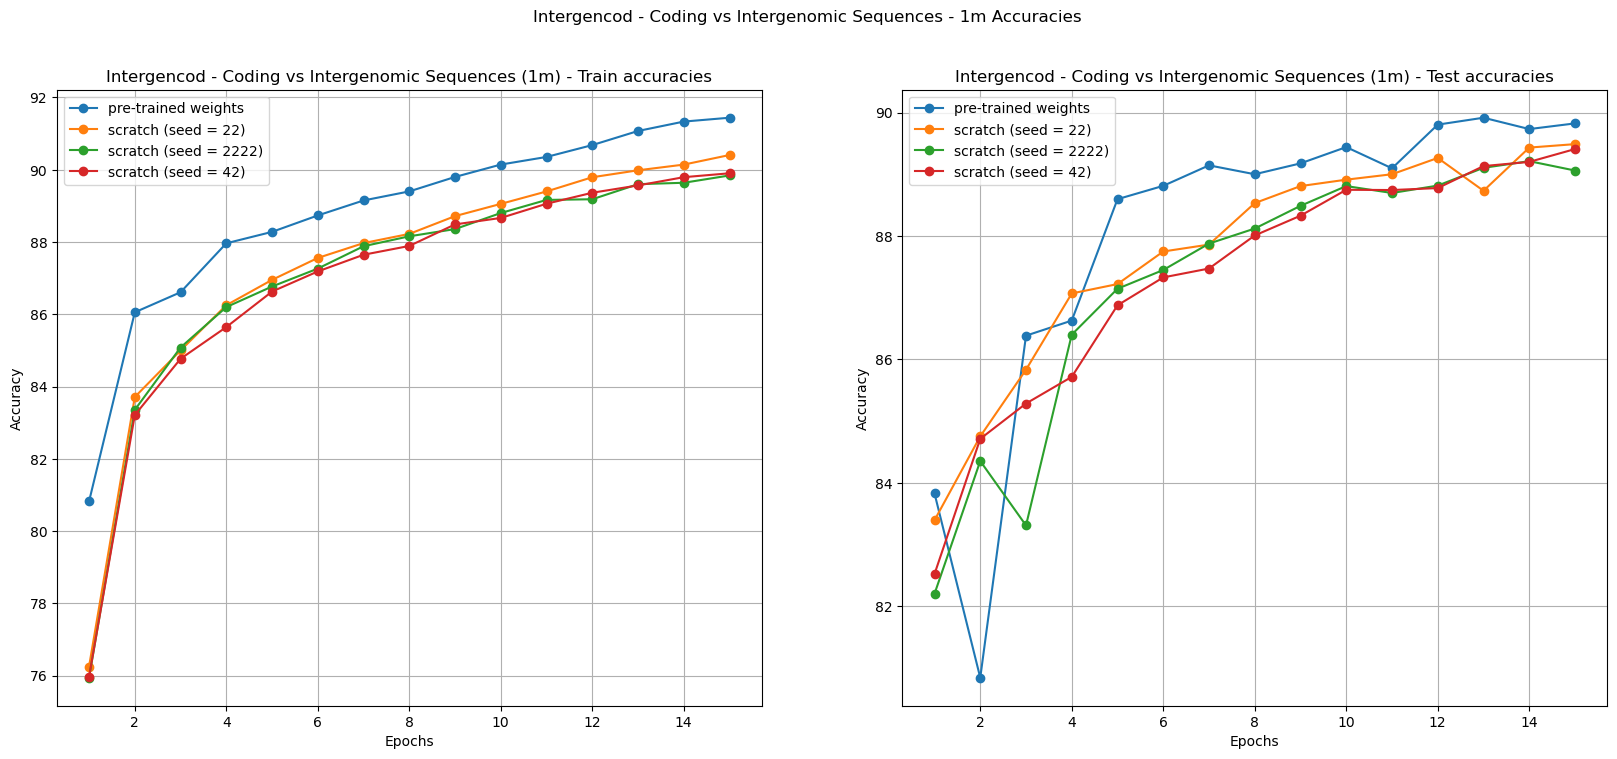

Plots generated and saved for intergencod (1m)


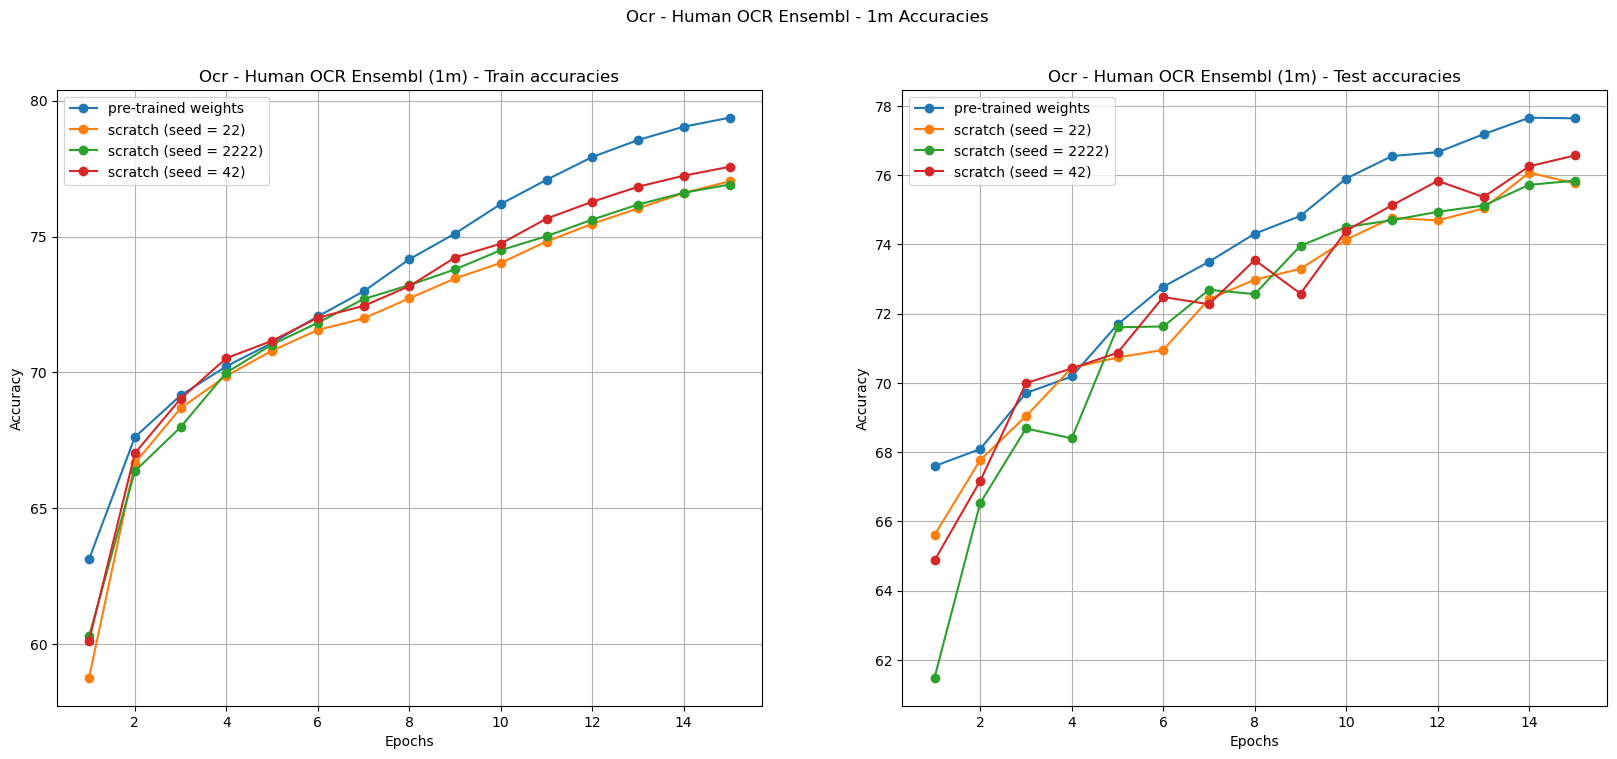

Plots generated and saved for ocr (1m)


In [87]:
# Plot training and test accuracies side by side for 1m files
plot_accuracies_side_by_side(all_data, '1m')

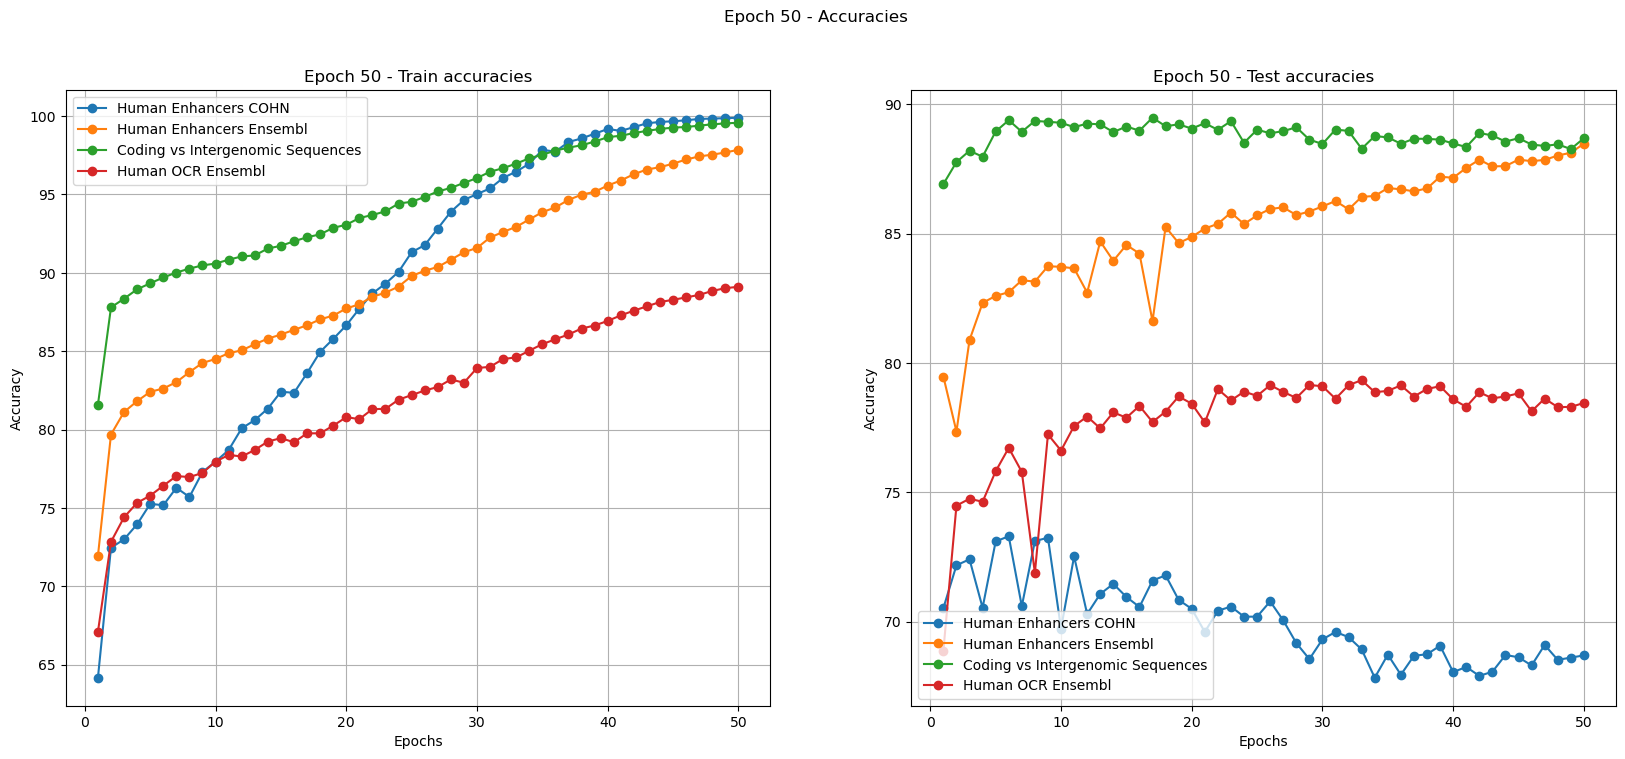

Plots generated and saved for Epoch 50 - Accuracies


In [88]:
# Plot epoch 50 accuracies side by side for all datasets
plot_epoch_50_accuracies_side_by_side(epoch_50_data)

In [89]:
# Example dataframe
data = {
    "Model": [
        "pi_15_1k", "pi_15_1m", "scratch_15_1k_22", "scratch_15_1k_42", "scratch_15_1k_2222",
        "scratch_15_1m_22", "scratch_15_1m_42", "scratch_15_1m_2222", "pi_50_1k"
    ],
    "Accuracy": [0.7195, 0.7189, 0.7179, 0.7188, 0.7192, 0.7178, 0.7132, 0.7145, 0.6870],
    "Precision": [0.7108, 0.7085, 0.7273, 0.7224, 0.7136, 0.7238, 0.7107, 0.7114, 0.6846],
    "Recall": [0.7401, 0.7438, 0.6972, 0.7107, 0.7323, 0.7044, 0.7191, 0.7216, 0.6934],
    "F1 Score": [0.7251, 0.7257, 0.7119, 0.7165, 0.7228, 0.7139, 0.7148, 0.7165, 0.6890]
}

df = pd.DataFrame(data)

# Display the title and dataframe
display(HTML("<h2>Model Performance Metrics COHN</h2>"))
display(df)

,Model,Accuracy,Precision,Recall,F1 Score
0,pi_15_1k,0.7195,0.7108,0.7401,0.7251
1,pi_15_1m,0.7189,0.7085,0.7438,0.7257
2,scratch_15_1k_22,0.7179,0.7273,0.6972,0.7119
3,scratch_15_1k_42,0.7188,0.7224,0.7107,0.7165
4,scratch_15_1k_2222,0.7192,0.7136,0.7323,0.7228
5,scratch_15_1m_22,0.7178,0.7238,0.7044,0.7139
6,scratch_15_1m_42,0.7132,0.7107,0.7191,0.7148
7,scratch_15_1m_2222,0.7145,0.7114,0.7216,0.7165
8,pi_50_1k,0.6870,0.6846,0.6934,0.6890


In [90]:

# Define the data with the correct order
data = {
    "Model": [
        "pi_15_1k", "pi_15_1m", "scratch_15_1k_22", "scratch_15_1k_42", "scratch_15_1k_2222",
        "scratch_15_1m_22", "scratch_15_1m_42", "scratch_15_1m_2222", "pi_50_1k"
    ],
    "Accuracy": [0.8236, 0.8276, 0.8490, 0.8351, 0.8261, 0.8321, 0.8435, 0.8367, 0.8848],
    "Precision": [0.8179, 0.8416, 0.8427, 0.8358, 0.8196, 0.8483, 0.8432, 0.8493, 0.8732],
    "Recall": [0.8326, 0.8076, 0.8602, 0.8340, 0.8361, 0.8090, 0.8438, 0.8186, 0.9002],
    "F1 Score": [0.8252, 0.8240, 0.8513, 0.8349, 0.8278, 0.8281, 0.8435, 0.8337, 0.8865]
}

df = pd.DataFrame(data)

# Display the title and dataframe
display(HTML("<h2>Model Performance Metrics Enhancers</h2>"))
display(df)


,Model,Accuracy,Precision,Recall,F1 Score
0,pi_15_1k,0.8236,0.8179,0.8326,0.8252
1,pi_15_1m,0.8276,0.8416,0.8076,0.8240
2,scratch_15_1k_22,0.8490,0.8427,0.8602,0.8513
3,scratch_15_1k_42,0.8351,0.8358,0.8340,0.8349
4,scratch_15_1k_2222,0.8261,0.8196,0.8361,0.8278
5,scratch_15_1m_22,0.8321,0.8483,0.8090,0.8281
6,scratch_15_1m_42,0.8435,0.8432,0.8438,0.8435
7,scratch_15_1m_2222,0.8367,0.8493,0.8186,0.8337
8,pi_50_1k,0.8848,0.8732,0.9002,0.8865


In [91]:

# Define the data with the correct order
data = {
    "Model": [
        "pi_15_1k", "pi_15_1m", "scratch_15_1k_22", "scratch_15_1k_42", "scratch_15_1k_2222",
        "scratch_15_1m_22", "scratch_15_1m_42", "scratch_15_1m_2222", "pi_50_1k"
    ],
    "Accuracy": [0.8982, 0.8876, 0.8932, 0.8845, 0.8949, 0.8914, 0.8941, 0.8906, 0.8869],
    "Precision": [0.8914, 0.8737, 0.8962, 0.8742, 0.9056, 0.8849, 0.8979, 0.8823, 0.8863],
    "Recall": [0.907, 0.9062, 0.8894, 0.8983, 0.8817, 0.8998, 0.8893, 0.9015, 0.8876],
    "F1 Score": [0.8991, 0.8897, 0.8928, 0.8861, 0.8935, 0.8923, 0.8936, 0.8918, 0.887]
}

df = pd.DataFrame(data)

# Display the title and dataframe
display(HTML("<h2>Model Performance Metrics Intergen_v_Coding</h2>"))
display(df)


,Model,Accuracy,Precision,Recall,F1 Score
0,pi_15_1k,0.8982,0.8914,0.9070,0.8991
1,pi_15_1m,0.8876,0.8737,0.9062,0.8897
2,scratch_15_1k_22,0.8932,0.8962,0.8894,0.8928
3,scratch_15_1k_42,0.8845,0.8742,0.8983,0.8861
4,scratch_15_1k_2222,0.8949,0.9056,0.8817,0.8935
5,scratch_15_1m_22,0.8914,0.8849,0.8998,0.8923
6,scratch_15_1m_42,0.8941,0.8979,0.8893,0.8936
7,scratch_15_1m_2222,0.8906,0.8823,0.9015,0.8918
8,pi_50_1k,0.8869,0.8863,0.8876,0.8870


In [92]:

# Define the data with the correct order
data = {
    "Model": [
        "pi_15_1k", "pi_15_1m", "scratch_15_1k_22", "scratch_15_1k_42", "scratch_15_1k_2222",
        "scratch_15_1m_22", "scratch_15_1m_42", "scratch_15_1m_2222", "pi_50_1k"
    ],
    "Accuracy": [0.7764, 0.7448, 0.7883, 0.755, 0.7576, 0.751, 0.7657, 0.7584, 0.7845],
    "Precision": [0.7898, 0.7452, 0.8140, 0.7846, 0.7541, 0.7525, 0.7598, 0.7264, 0.7836],
    "Recall": [0.7533, 0.7440, 0.7474, 0.7030, 0.7644, 0.7481, 0.7771, 0.8293, 0.7862],
    "F1 Score": [0.7711, 0.7446, 0.7793, 0.7416, 0.7592, 0.7503, 0.7683, 0.7744, 0.7849]
}

df = pd.DataFrame(data)

# Display the title and dataframe
display(HTML("<h2>Model Performance Metrics OCR</h2>"))
display(df)


,Model,Accuracy,Precision,Recall,F1 Score
0,pi_15_1k,0.7764,0.7898,0.7533,0.7711
1,pi_15_1m,0.7448,0.7452,0.7440,0.7446
2,scratch_15_1k_22,0.7883,0.8140,0.7474,0.7793
3,scratch_15_1k_42,0.7550,0.7846,0.7030,0.7416
4,scratch_15_1k_2222,0.7576,0.7541,0.7644,0.7592
5,scratch_15_1m_22,0.7510,0.7525,0.7481,0.7503
6,scratch_15_1m_42,0.7657,0.7598,0.7771,0.7683
7,scratch_15_1m_2222,0.7584,0.7264,0.8293,0.7744
8,pi_50_1k,0.7845,0.7836,0.7862,0.7849


In [59]:
# Define the data for each task
data_cohn = {
    "Model": [
        "pi_15_1k", "pi_15_1m", "scratch_15_1k_22", "scratch_15_1k_42", "scratch_15_1k_2222",
        "scratch_15_1m_22", "scratch_15_1m_42", "scratch_15_1m_2222", "pi_50_1k"
    ],
    "Accuracy": [0.7195, 0.7189, 0.7179, 0.7188, 0.7192, 0.7178, 0.7132, 0.7145, 0.6870]
}

data_enhancers = {
    "Model": [
        "pi_15_1k", "pi_15_1m", "scratch_15_1k_22", "scratch_15_1k_42", "scratch_15_1k_2222",
        "scratch_15_1m_22", "scratch_15_1m_42", "scratch_15_1m_2222", "pi_50_1k"
    ],
    "Accuracy": [0.8236, 0.8276, 0.8490, 0.8351, 0.8261, 0.8321, 0.8435, 0.8367, 0.8848]
}

data_intergen_coding = {
    "Model": [
        "pi_15_1k", "pi_15_1m", "scratch_15_1k_22", "scratch_15_1k_42", "scratch_15_1k_2222",
        "scratch_15_1m_22", "scratch_15_1m_42", "scratch_15_1m_2222", "pi_50_1k"
    ],
    "Accuracy": [0.8982, 0.8876, 0.8932, 0.8845, 0.8949, 0.8914, 0.8941, 0.8906, 0.8869]
}

data_ocr = {
    "Model": [
        "pi_15_1k", "pi_15_1m", "scratch_15_1k_22", "scratch_15_1k_42", "scratch_15_1k_2222",
        "scratch_15_1m_22", "scratch_15_1m_42", "scratch_15_1m_2222", "pi_50_1k"
    ],
    "Accuracy": [0.7764, 0.7448, 0.7883, 0.755, 0.7576, 0.751, 0.7657, 0.7584, 0.7845]
}

# Create dataframes
df_cohn = pd.DataFrame(data_cohn).set_index('Model')
df_enhancers = pd.DataFrame(data_enhancers).set_index('Model')
df_intergen_coding = pd.DataFrame(data_intergen_coding).set_index('Model')
df_ocr = pd.DataFrame(data_ocr).set_index('Model')

# Combine dataframes
combined_df = pd.concat([df_cohn, df_enhancers, df_intergen_coding, df_ocr], axis=1)
combined_df.columns = ['COHN', 'Enhancers', 'Intergen_v_Coding', 'OCR']

# Display the combined dataframe
display(HTML("<h2>Combined Model Performance Accuracies</h2>"))
display(combined_df)

,COHN,Enhancers,Intergen_v_Coding,OCR
Model,,,,
pi_15_1k,0.7195,0.8236,0.8982,0.7764
pi_15_1m,0.7189,0.8276,0.8876,0.7448
scratch_15_1k_22,0.7179,0.8490,0.8932,0.7883
scratch_15_1k_42,0.7188,0.8351,0.8845,0.7550
scratch_15_1k_2222,0.7192,0.8261,0.8949,0.7576
scratch_15_1m_22,0.7178,0.8321,0.8914,0.7510
scratch_15_1m_42,0.7132,0.8435,0.8941,0.7657
scratch_15_1m_2222,0.7145,0.8367,0.8906,0.7584
pi_50_1k,0.6870,0.8848,0.8869,0.7845


In [60]:
import os
import json
import pandas as pd

# Get the current directory for interactive environments
current_directory = os.getcwd()

# Tasks
tasks = ['cohn', 'enhancers', 'intergencod', 'ocr']

# Initialize an empty list to store the results
results = []

# Iterate through each task folder
for task in tasks:
    task_folder = os.path.join(current_directory, f'all_{task}')
    # Iterate through each file in the task folder
    for file_name in os.listdir(task_folder):
        if file_name.endswith('.json'):
            file_path = os.path.join(task_folder, file_name)
            # Read the JSON file
            with open(file_path, 'r') as file:
                data = json.load(file)
                # Extract the last value from test_accuracies
                last_test_accuracy = data['test_accuracies'][-1]
                # Append the result to the list
                results.append({'File Name': file_name, 'Task': task, 'Test Accuracy': last_test_accuracy})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_df.to_csv('test_accuracy_results.csv', index=False)

# Display the DataFrame
print(results_df)


                                         File Name         Task  Test Accuracy
0                    accuracies_cohn_15_pi_1k.json         cohn      71.948762
1                    accuracies_cohn_15_pi_1m.json         cohn      71.891192
2            accuracies_cohn_15_scratch_1k_22.json         cohn      71.790443
3          accuracies_cohn_15_scratch_1k_2222.json         cohn      71.919977
4            accuracies_cohn_15_scratch_1k_42.json         cohn      71.876799
5            accuracies_cohn_15_scratch_1m_22.json         cohn      71.776051
6          accuracies_cohn_15_scratch_1m_2222.json         cohn      71.445020
7            accuracies_cohn_15_scratch_1m_42.json         cohn      71.315486
8                    accuracies_cohn_50_pi_1k.json         cohn      68.696028
9               accuracies_enhancers_15_pi_1k.json    enhancers      84.979012
10              accuracies_enhancers_15_pi_1m.json    enhancers      82.363578
11      accuracies_enhancers_15_scratch_1k_22.json  